In [32]:
try:
    from eunjeon import Mecab
    import eunjeon
except:
    from konlpy.tag import Mecab
import konlpy

# numpy & pandas
import numpy as np
import pandas as pd

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Embedding, Activation, LSTM, Bidirectional, GRU, Softmax, Dropout, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# my lib
import textlib as tl
import Word2VecModel as wv

import pandas as pd

In [3]:
w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_'
#w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_'
#w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_'
is_all_tag = True

In [4]:
# 여러개의 w2v 모델을 만들기 위한 table
MODEL_COUNT = 9
MODEL_NAMES = ['V10000_E128_W3','V10000_E128_W4','V10000_E128_W5',
               'V10000_E256_W3','V10000_E256_W4','V10000_E256_W5',
               'V10000_E384_W3','V10000_E384_W4','V10000_E384_W5']

In [5]:
# loss, accuracy plot
def plot_hist(hist):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2)
    loss_ax = axes[0]
    acc_ax = axes[1]

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower right')

    plt.show()    

In [57]:
# sop dataset 읽어옴
input_file_name = '../TCL2021_Telco_Embedding_Dataset/dataset/sop_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')

print( df.shape )


(65635, 6)


In [6]:
# null 인 row가 하나라도 있으면 삭제
df.dropna(axis=0, inplace=True)
print( df.shape )

(65635, 6)


In [40]:
# dataset의 문장 길이 통계
def avg(it):
    return sum(it) / len(it)

lens = [len(s) for s in df['sentence'].values]
#lens = [len(s) for s in X]

print( min(lens) )
print( max(lens) )
print( avg(lens) )

34
3222
295.5143749523882


In [59]:
# label 통계
df.groupby('label_clean').count()

,담당BA부서,date,co,sentence,label_org
label_clean,,,,,
MPAMS,333,333,333,333,333
MVNO,380,380,380,380,380
SKT eService-Tsales,98,98,98,98,98
SWING CTC,4623,4623,4623,4623,4623
SWING DBM,408,408,408,408,408
SWING NIS,385,385,385,385,385
SWING Payment,6463,6463,6463,6463,6463
SWING Portal,203,203,203,203,203
SWING SSO,403,403,403,403,403


In [60]:
# 첫 모델은 sentence와 label만 써보자
# df_zip = df[ ['sentence', 'label'] ]

y = df.pop('label_clean')
X = df.pop('sentence')

In [61]:
# 문자열로 되어 있는 label을 categorical value로 변환
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

In [62]:
# 잘 변환됐나?
print( y )
print( label_encoder.inverse_transform(y) )

[ 3 24  6 ...  6 20 32]
['SWING CTC' 'SWING 파트너관리(PRM)' 'SWING Payment' ... 'SWING Payment'
 'SWING 자원 - 계약서관리' '상품-무선']


In [63]:
w2v_model = wv.Word2VecModel()
w2v_model.load(w2v_model_file_name_prefix + MODEL_NAMES[2])
print(f'{w2v_model_file_name_prefix + MODEL_NAMES[2]} loaded')

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E128_W5 loaded


In [64]:
# 전처리 테스트
print('--- raw sentence ---')
print( X[0] )
print()

print('--- 클렌징된 sentence ---')
cleansed_text = tl.clean_text( X[0] )
print( cleansed_text )
print()

print('--- 구두점 단위로 잘라서 배열화 ---')
tokenized_sentence = tl.segment_sentences(cleansed_text)
print( tokenized_sentence )
print()

print('--- 형태소 ---')
# SOR이니까 변경/요청 이란 단어는 항상 들어가므로 삭제
#ignore_words = ['변경','요청','SWING']
corpora = ' '.join(tl.get_corpora(sentences=tokenized_sentence,
                                  ignore_words=[],
                                  tagger=None,
                                  isAllTag=is_all_tag)).split(' ')
print(corpora)
print()

sequence = w2v_model.get_words_indexes(corpora)
print('word id')
print(sequence)
print()

print(y[0])
print(label_encoder.inverse_transform([y[0]]))


--- raw sentence ---
[Swing]고객상담]_상담예약 한적없으나 SMS 수신 되어 문의 . [Swing]고객상담]_상담예약 한적없으나 SMS 수신 되어 문의

010-9425-6450==970627


통합접척이력 조회> SMS/MMS 수신 2019-05-28 :15:45 
[SKT] 16시 상담예약 완료.
01094256450
으로 전화드리겠습니다.

SMS 수신되어 확인 부탁 드립니다

해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다 

요청자  최 문경 : 010-4035-3522

--- 클렌징된 sentence ---
 Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의 . Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의

 


통합접척이력 조회 SMS/MMS 수신 
 SKT 시 상담예약 완료.
 
으로 전화드리겠습니다.

SMS 수신되어 확인 부탁 드립니다

해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다 

요청자 최 문경 

--- 구두점 단위로 잘라서 배열화 ---
['Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의', 'Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의', '통합접척이력 조회 SMS/MMS 수신', 'SKT 시 상담예약 완료', '으로 전화드리겠습니다', 'SMS 수신되어 확인 부탁 드립니다', '해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다', '요청자 최 문경']

--- 형태소 ---
['Swing', '고객', '상담', '_', '상담', '예약', '한', '적', '없', '으나', 'SMS', '수신', '되', '어', '문의', 'Swing', '고객', '상담', '_', '상담', '예약', '한', '적', '없', '으나', 'SMS', '수신', '되', '어', '문의', 

In [6]:
# raw 문장을 전처리(쪼개고 형태소로 분리하고 단어id로 바꾸고 padding까지)
def preprocess_sentence(X, w2v_model, max_sentence_len=256, ignore_words=[]):
    # 문장 전처리
    preprocessed_X = []
    print(f'{len(X)} 개의 데이터 존재 확인!')

    for i, text in enumerate(X):
        try:
            # 클렌징
            cleansed_text = tl.clean_text(text)
        except TypeError:
            print(f'      {i+1} 번째 데이터에 문제가 있어 skip!')
            continue

        # 문장으로 분리하여 배열로 리턴
        sentences = tl.segment_sentences(cleansed_text)
        # 문장 배열을 입릭으로 받아 형태소로 쪼갠 뒤, 다시 하나의 문자열로 변환하여 저장
        corpora = ' '.join(tl.get_corpora(sentences, None, True)).split(' ')
        # 단어들을 id로 변환
        sequence = w2v_model.get_words_indexes(corpora)
        
        preprocessed_X.append(sequence)

        if i % 5000 == 0 and i > 0:
            print(f'      {i} 번째 데이터 처리 완료!')

    print('데이터 전체 처리 완료!')
    # 최대 길이까지만 문장 사용. 짧은 문장은 뒤쪽에 PADDING token으로 채워서 리턴
    preprocessed_X = pad_sequences( preprocessed_X, 
                                   maxlen=max_sentence_len, 
                                   padding='post', 
                                   value=w2v_model.word2index[wv.PAD_TOKEN] )
    print('PADDING 완료!')    
    return preprocessed_X
    

In [66]:
MAX_SENTENCE_LEN = 256
preprocessed_X = preprocess_sentence(X, w2v_model, MAX_SENTENCE_LEN, [])

65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!


In [67]:
# train / test 분리
X_train, X_test, y_train, y_test = \
    train_test_split(preprocessed_X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
# 배열을 numpy 로 변경
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)

print( len(X_train) )
print( len(X_test) )
print( len(y_train) )
print( len(y_test) )

52508
13127
52508
13127


In [69]:
X_train.shape

(52508, 256)

In [7]:
# DL 모델. 
class SOPClassifier(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, hidden_dim,
                 batch_size, embedding_weights, train_embedding_layer, dropout, classes):
        super(SOPClassifier, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_weights])
        self.lstm = Bidirectional( LSTM(self.dec_units) )
        self.fc1 = Dense(hidden_dim, activation='relu')
        self.fc2 = Dense(hidden_dim, activation='relu')        
        self.fc3 = Dense(classes, activation='softmax')
        self.do1 = Dropout(dropout)
        self.do2 = Dropout(dropout)
        self.do3 = Dropout(dropout)
        
        self.embedding.trainable = train_embedding_layer
        
    # 단어id 벡터 -> embedding layer -> bilstm -> dropout -> (opt)attention -> fc -> droupout -> fc(softmax)

    def call(self, x):
        # (batch, seq) -> (batch, seq, embedding_dim)        
        x = self.embedding(x)

        # (batch, seq, embedding_dim) -> (batch, seq, embedding_dim*2)        
        x = self.lstm(x)
        x = self.do1(x)        

        # (batch, embedding_dim) -> (batch, 128)    
        x = self.fc1(x)
        x = self.do2(x)
        x = self.fc2(x)
        x = self.do3(x)
        x = self.fc3(x)
        
        return x


In [23]:
def train_and_evaluate(vocab_size, embedding_dim, dec_units, hidden_units, epochs, batch_size, 
       weights, train_embedding_layer, dropout, classes, model_file_name):
    model = SOPClassifier(
        vocab_size, 
        embedding_dim, 
        dec_units, 
        hidden_units,
        batch_size,
        weights,
        train_embedding_layer,
        dropout,
        classes
    )

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # early stoppiong. 3번까진 봐준다.
    es = EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=3,
                       mode='auto')

    mc = ModelCheckpoint(model_file_name, monitor='val_loss', mode='min', save_best_only=True)    
    
    history = model.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2,
                        callbacks=[es, mc])
    
    test_score = model.evaluate(X_test, y_test, verbose=2)
    
    plot_hist(history)
    
    return model, history, test_score

## import하고 여기만 실행하셈

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E128_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 49s 129ms/step - loss: 1.5900 - accuracy: 0.5836 - val_loss: 0.9487 - val_accuracy: 0.7454


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 2/20
329/329 [==============================] - 42s 127ms/step - loss: 0.9912 - accuracy: 0.7391 - val_loss: 0.7895 - val_accuracy: 0.7849


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 3/20
329/329 [==============================] - 43s 129ms/step - loss: 0.8650 - accuracy: 0.7693 - val_loss: 0.7531 - val_accuracy: 0.7873


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 4/20
329/329 [==============================] - 43s 132ms/step - loss: 0.8071 - accuracy: 0.7821 - val_loss: 0.7063 - val_accuracy: 0.7968


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 5/20
329/329 [==============================] - 43s 130ms/step - loss: 0.7429 - accuracy: 0.7976 - val_loss: 0.6815 - val_accuracy: 0.8029


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 6/20
329/329 [==============================] - 43s 129ms/step - loss: 0.7092 - accuracy: 0.8061 - val_loss: 0.6704 - val_accuracy: 0.8058


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 7/20
329/329 [==============================] - 43s 131ms/step - loss: 0.6742 - accuracy: 0.8126 - val_loss: 0.6505 - val_accuracy: 0.8171


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 8/20
329/329 [==============================] - 43s 130ms/step - loss: 0.6471 - accuracy: 0.8199 - val_loss: 0.6553 - val_accuracy: 0.8182
Epoch 9/20
329/329 [==============================] - 43s 130ms/step - loss: 0.6294 - accuracy: 0.8240 - val_loss: 0.6367 - val_accuracy: 0.8158


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 10/20
329/329 [==============================] - 42s 129ms/step - loss: 0.5995 - accuracy: 0.8314 - val_loss: 0.6286 - val_accuracy: 0.8227


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 11/20
329/329 [==============================] - 43s 130ms/step - loss: 0.5785 - accuracy: 0.8357 - val_loss: 0.6287 - val_accuracy: 0.8239
Epoch 12/20
329/329 [==============================] - 43s 129ms/step - loss: 0.5554 - accuracy: 0.8417 - val_loss: 0.6121 - val_accuracy: 0.8209


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 13/20
329/329 [==============================] - 43s 131ms/step - loss: 0.5389 - accuracy: 0.8439 - val_loss: 0.6348 - val_accuracy: 0.8229
Epoch 14/20
329/329 [==============================] - 43s 130ms/step - loss: 0.5281 - accuracy: 0.8461 - val_loss: 0.6201 - val_accuracy: 0.8237
Epoch 15/20
329/329 [==============================] - 42s 128ms/step - loss: 0.5030 - accuracy: 0.8527 - val_loss: 0.6032 - val_accuracy: 0.8275


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W3\assets


Epoch 16/20
329/329 [==============================] - 44s 133ms/step - loss: 0.4827 - accuracy: 0.8593 - val_loss: 0.6056 - val_accuracy: 0.8324
Epoch 17/20
329/329 [==============================] - 43s 130ms/step - loss: 0.4680 - accuracy: 0.8617 - val_loss: 0.6263 - val_accuracy: 0.8315
Epoch 18/20
329/329 [==============================] - 44s 133ms/step - loss: 0.4513 - accuracy: 0.8671 - val_loss: 0.6183 - val_accuracy: 0.8326
411/411 - 9s - loss: 0.6021 - accuracy: 0.8371


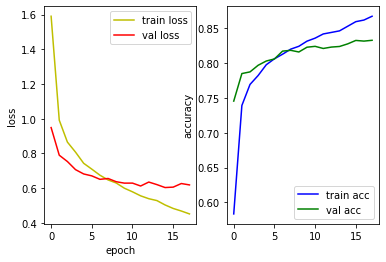

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E128_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 49s 133ms/step - loss: 1.5772 - accuracy: 0.5858 - val_loss: 0.9269 - val_accuracy: 0.7536


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 2/20
329/329 [==============================] - 42s 127ms/step - loss: 0.9753 - accuracy: 0.7417 - val_loss: 0.7921 - val_accuracy: 0.7799


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 3/20
329/329 [==============================] - 40s 121ms/step - loss: 0.8621 - accuracy: 0.7678 - val_loss: 0.7321 - val_accuracy: 0.7944


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 4/20
329/329 [==============================] - 40s 122ms/step - loss: 0.7959 - accuracy: 0.7885 - val_loss: 0.6921 - val_accuracy: 0.8023


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 5/20
329/329 [==============================] - 40s 122ms/step - loss: 0.7549 - accuracy: 0.7961 - val_loss: 0.6749 - val_accuracy: 0.8088


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 6/20
329/329 [==============================] - 40s 122ms/step - loss: 0.7232 - accuracy: 0.8046 - val_loss: 0.6606 - val_accuracy: 0.8130


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 7/20
329/329 [==============================] - 40s 121ms/step - loss: 0.6784 - accuracy: 0.8144 - val_loss: 0.6640 - val_accuracy: 0.8082
Epoch 8/20
329/329 [==============================] - 40s 123ms/step - loss: 0.6563 - accuracy: 0.8171 - val_loss: 0.6343 - val_accuracy: 0.8170


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 9/20
329/329 [==============================] - 40s 121ms/step - loss: 0.6230 - accuracy: 0.8250 - val_loss: 0.6281 - val_accuracy: 0.8204


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 10/20
329/329 [==============================] - 40s 122ms/step - loss: 0.6112 - accuracy: 0.8285 - val_loss: 0.6242 - val_accuracy: 0.8195


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 11/20
329/329 [==============================] - 40s 123ms/step - loss: 0.5809 - accuracy: 0.8346 - val_loss: 0.6188 - val_accuracy: 0.8236


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 12/20
329/329 [==============================] - 40s 121ms/step - loss: 0.5669 - accuracy: 0.8375 - val_loss: 0.6132 - val_accuracy: 0.8224


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 13/20
329/329 [==============================] - 40s 121ms/step - loss: 0.5420 - accuracy: 0.8449 - val_loss: 0.6097 - val_accuracy: 0.8251


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 14/20
329/329 [==============================] - 41s 123ms/step - loss: 0.5287 - accuracy: 0.8473 - val_loss: 0.6025 - val_accuracy: 0.8288


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W4\assets


Epoch 15/20
329/329 [==============================] - 40s 122ms/step - loss: 0.5097 - accuracy: 0.8509 - val_loss: 0.6210 - val_accuracy: 0.8275
Epoch 16/20
329/329 [==============================] - 40s 122ms/step - loss: 0.4982 - accuracy: 0.8525 - val_loss: 0.6179 - val_accuracy: 0.8269
Epoch 17/20
329/329 [==============================] - 40s 121ms/step - loss: 0.4721 - accuracy: 0.8598 - val_loss: 0.6186 - val_accuracy: 0.8288
411/411 - 7s - loss: 0.5806 - accuracy: 0.8386


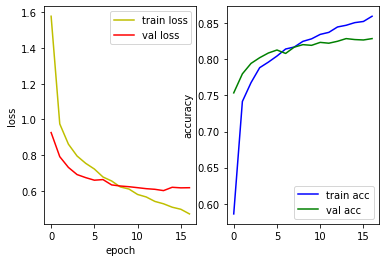

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E128_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 44s 123ms/step - loss: 1.6050 - accuracy: 0.5812 - val_loss: 0.9559 - val_accuracy: 0.7510


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 2/20
329/329 [==============================] - 40s 122ms/step - loss: 0.9989 - accuracy: 0.7340 - val_loss: 0.8166 - val_accuracy: 0.7767


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 3/20
329/329 [==============================] - 40s 121ms/step - loss: 0.8725 - accuracy: 0.7670 - val_loss: 0.7441 - val_accuracy: 0.7929


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 4/20
329/329 [==============================] - 40s 121ms/step - loss: 0.8005 - accuracy: 0.7844 - val_loss: 0.7080 - val_accuracy: 0.7930


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 5/20
329/329 [==============================] - 40s 121ms/step - loss: 0.7548 - accuracy: 0.7955 - val_loss: 0.6941 - val_accuracy: 0.8016


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 6/20
329/329 [==============================] - 40s 121ms/step - loss: 0.7115 - accuracy: 0.8039 - val_loss: 0.6773 - val_accuracy: 0.8060


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 7/20
329/329 [==============================] - 40s 121ms/step - loss: 0.6857 - accuracy: 0.8118 - val_loss: 0.6690 - val_accuracy: 0.8116


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 8/20
329/329 [==============================] - 40s 121ms/step - loss: 0.6633 - accuracy: 0.8164 - val_loss: 0.6467 - val_accuracy: 0.8164


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 9/20
329/329 [==============================] - 41s 123ms/step - loss: 0.6361 - accuracy: 0.8209 - val_loss: 0.6467 - val_accuracy: 0.8154


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 10/20
329/329 [==============================] - 40s 122ms/step - loss: 0.6168 - accuracy: 0.8269 - val_loss: 0.6359 - val_accuracy: 0.8130


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 11/20
329/329 [==============================] - 40s 123ms/step - loss: 0.5883 - accuracy: 0.8326 - val_loss: 0.6083 - val_accuracy: 0.8212


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 12/20
329/329 [==============================] - 40s 122ms/step - loss: 0.5678 - accuracy: 0.8385 - val_loss: 0.6038 - val_accuracy: 0.8239


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E128_W5\assets


Epoch 13/20
329/329 [==============================] - 40s 123ms/step - loss: 0.5531 - accuracy: 0.8405 - val_loss: 0.6189 - val_accuracy: 0.8245
Epoch 14/20
329/329 [==============================] - 40s 123ms/step - loss: 0.5381 - accuracy: 0.8462 - val_loss: 0.6088 - val_accuracy: 0.8240
Epoch 15/20
329/329 [==============================] - 40s 122ms/step - loss: 0.5133 - accuracy: 0.8504 - val_loss: 0.6196 - val_accuracy: 0.8300
411/411 - 7s - loss: 0.6005 - accuracy: 0.8315


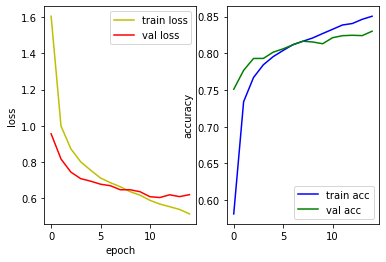

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E256_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 51s 143ms/step - loss: 1.5158 - accuracy: 0.6060 - val_loss: 0.8921 - val_accuracy: 0.7604


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 2/20
329/329 [==============================] - 47s 142ms/step - loss: 0.9449 - accuracy: 0.7539 - val_loss: 0.7946 - val_accuracy: 0.7821


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 3/20
329/329 [==============================] - 47s 143ms/step - loss: 0.8230 - accuracy: 0.7838 - val_loss: 0.7299 - val_accuracy: 0.7965


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 4/20
329/329 [==============================] - 47s 143ms/step - loss: 0.7579 - accuracy: 0.7973 - val_loss: 0.7040 - val_accuracy: 0.8064


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 5/20
329/329 [==============================] - 47s 141ms/step - loss: 0.7007 - accuracy: 0.8092 - val_loss: 0.6685 - val_accuracy: 0.8054


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 6/20
329/329 [==============================] - 47s 144ms/step - loss: 0.6717 - accuracy: 0.8167 - val_loss: 0.6387 - val_accuracy: 0.8171


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 7/20
329/329 [==============================] - 47s 143ms/step - loss: 0.6279 - accuracy: 0.8250 - val_loss: 0.6406 - val_accuracy: 0.8182
Epoch 8/20
329/329 [==============================] - 47s 144ms/step - loss: 0.6045 - accuracy: 0.8309 - val_loss: 0.6323 - val_accuracy: 0.8237


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 9/20
329/329 [==============================] - 47s 143ms/step - loss: 0.5764 - accuracy: 0.8372 - val_loss: 0.6470 - val_accuracy: 0.8101
Epoch 10/20
329/329 [==============================] - 47s 144ms/step - loss: 0.5477 - accuracy: 0.8442 - val_loss: 0.6014 - val_accuracy: 0.8276


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 11/20
329/329 [==============================] - 47s 143ms/step - loss: 0.5338 - accuracy: 0.8476 - val_loss: 0.6146 - val_accuracy: 0.8285
Epoch 12/20
329/329 [==============================] - 47s 144ms/step - loss: 0.5113 - accuracy: 0.8537 - val_loss: 0.5973 - val_accuracy: 0.8324


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W3\assets


Epoch 13/20
329/329 [==============================] - 47s 144ms/step - loss: 0.4915 - accuracy: 0.8569 - val_loss: 0.6137 - val_accuracy: 0.8244
Epoch 14/20
329/329 [==============================] - 46s 141ms/step - loss: 0.4648 - accuracy: 0.8649 - val_loss: 0.6141 - val_accuracy: 0.8358
Epoch 15/20
329/329 [==============================] - 46s 141ms/step - loss: 0.4519 - accuracy: 0.8682 - val_loss: 0.6152 - val_accuracy: 0.8309
411/411 - 8s - loss: 0.5904 - accuracy: 0.8363


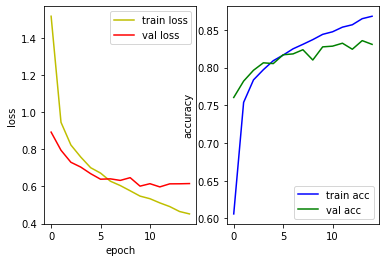

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E256_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 53s 144ms/step - loss: 1.5264 - accuracy: 0.6037 - val_loss: 0.8948 - val_accuracy: 0.7604


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 2/20
329/329 [==============================] - 47s 144ms/step - loss: 0.9702 - accuracy: 0.7469 - val_loss: 0.7792 - val_accuracy: 0.7828


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 3/20
329/329 [==============================] - 47s 144ms/step - loss: 0.8433 - accuracy: 0.7759 - val_loss: 0.7273 - val_accuracy: 0.7976


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 4/20
329/329 [==============================] - 47s 144ms/step - loss: 0.7646 - accuracy: 0.7933 - val_loss: 0.6917 - val_accuracy: 0.8003


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 5/20
329/329 [==============================] - 49s 149ms/step - loss: 0.7110 - accuracy: 0.8057 - val_loss: 0.6672 - val_accuracy: 0.8082


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 6/20
329/329 [==============================] - 47s 142ms/step - loss: 0.6692 - accuracy: 0.8170 - val_loss: 0.6488 - val_accuracy: 0.8139


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 7/20
329/329 [==============================] - 49s 148ms/step - loss: 0.6354 - accuracy: 0.8233 - val_loss: 0.6434 - val_accuracy: 0.8169


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 8/20
329/329 [==============================] - 47s 142ms/step - loss: 0.6142 - accuracy: 0.8271 - val_loss: 0.6165 - val_accuracy: 0.8237


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 9/20
329/329 [==============================] - 47s 142ms/step - loss: 0.5850 - accuracy: 0.8356 - val_loss: 0.6053 - val_accuracy: 0.8252


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W4\assets


Epoch 10/20
329/329 [==============================] - 47s 142ms/step - loss: 0.5581 - accuracy: 0.8428 - val_loss: 0.6323 - val_accuracy: 0.8200
Epoch 11/20
329/329 [==============================] - 47s 143ms/step - loss: 0.5338 - accuracy: 0.8469 - val_loss: 0.6233 - val_accuracy: 0.8257
Epoch 12/20
329/329 [==============================] - 47s 143ms/step - loss: 0.5128 - accuracy: 0.8532 - val_loss: 0.6231 - val_accuracy: 0.8203
411/411 - 8s - loss: 0.5898 - accuracy: 0.8309


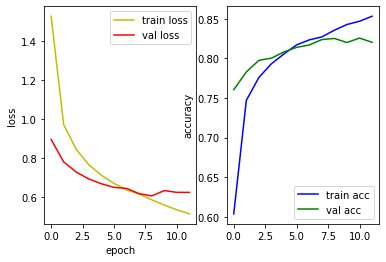

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E256_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 51s 143ms/step - loss: 1.5117 - accuracy: 0.6094 - val_loss: 0.8875 - val_accuracy: 0.7586


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 2/20
329/329 [==============================] - 47s 142ms/step - loss: 0.9433 - accuracy: 0.7547 - val_loss: 0.7927 - val_accuracy: 0.7795


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 3/20
329/329 [==============================] - 47s 142ms/step - loss: 0.8220 - accuracy: 0.7827 - val_loss: 0.7260 - val_accuracy: 0.7991


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 4/20
329/329 [==============================] - 47s 141ms/step - loss: 0.7552 - accuracy: 0.7949 - val_loss: 0.6841 - val_accuracy: 0.8061


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 5/20
329/329 [==============================] - 47s 142ms/step - loss: 0.7072 - accuracy: 0.8081 - val_loss: 0.6824 - val_accuracy: 0.8045


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 6/20
329/329 [==============================] - 47s 142ms/step - loss: 0.6709 - accuracy: 0.8155 - val_loss: 0.6433 - val_accuracy: 0.8169


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 7/20
329/329 [==============================] - 47s 142ms/step - loss: 0.6399 - accuracy: 0.8248 - val_loss: 0.6473 - val_accuracy: 0.8175
Epoch 8/20
329/329 [==============================] - 47s 142ms/step - loss: 0.6186 - accuracy: 0.8245 - val_loss: 0.6309 - val_accuracy: 0.8191


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 9/20
329/329 [==============================] - 47s 142ms/step - loss: 0.5913 - accuracy: 0.8341 - val_loss: 0.6065 - val_accuracy: 0.8257


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 10/20
329/329 [==============================] - 47s 142ms/step - loss: 0.5622 - accuracy: 0.8407 - val_loss: 0.5947 - val_accuracy: 0.8277


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 11/20
329/329 [==============================] - 47s 142ms/step - loss: 0.5367 - accuracy: 0.8458 - val_loss: 0.6068 - val_accuracy: 0.8300
Epoch 12/20
329/329 [==============================] - 46s 141ms/step - loss: 0.5190 - accuracy: 0.8494 - val_loss: 0.5933 - val_accuracy: 0.8305


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 13/20
329/329 [==============================] - 46s 141ms/step - loss: 0.4920 - accuracy: 0.8564 - val_loss: 0.5875 - val_accuracy: 0.8323


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 14/20
329/329 [==============================] - 46s 140ms/step - loss: 0.4796 - accuracy: 0.8600 - val_loss: 0.5850 - val_accuracy: 0.8305


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E256_W5\assets


Epoch 15/20
329/329 [==============================] - 46s 141ms/step - loss: 0.4573 - accuracy: 0.8649 - val_loss: 0.6035 - val_accuracy: 0.8326
Epoch 16/20
329/329 [==============================] - 46s 141ms/step - loss: 0.4398 - accuracy: 0.8709 - val_loss: 0.6162 - val_accuracy: 0.8330
Epoch 17/20
329/329 [==============================] - 46s 141ms/step - loss: 0.4191 - accuracy: 0.8743 - val_loss: 0.6046 - val_accuracy: 0.8340
411/411 - 8s - loss: 0.5927 - accuracy: 0.8405


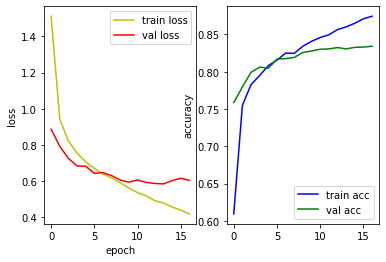

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E384_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 56s 160ms/step - loss: 1.5194 - accuracy: 0.6097 - val_loss: 0.9087 - val_accuracy: 0.7571


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 2/20
329/329 [==============================] - 52s 159ms/step - loss: 0.9634 - accuracy: 0.7499 - val_loss: 0.7675 - val_accuracy: 0.7909


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 3/20
329/329 [==============================] - 52s 159ms/step - loss: 0.8260 - accuracy: 0.7800 - val_loss: 0.7076 - val_accuracy: 0.7953


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 4/20
329/329 [==============================] - 52s 159ms/step - loss: 0.7460 - accuracy: 0.7993 - val_loss: 0.6735 - val_accuracy: 0.8090


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 5/20
329/329 [==============================] - 52s 159ms/step - loss: 0.6915 - accuracy: 0.8112 - val_loss: 0.6649 - val_accuracy: 0.8118


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 6/20
329/329 [==============================] - 52s 159ms/step - loss: 0.6507 - accuracy: 0.8203 - val_loss: 0.6583 - val_accuracy: 0.8141


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 7/20
329/329 [==============================] - 53s 160ms/step - loss: 0.6106 - accuracy: 0.8306 - val_loss: 0.6180 - val_accuracy: 0.8239


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 8/20
329/329 [==============================] - 52s 159ms/step - loss: 0.5825 - accuracy: 0.8364 - val_loss: 0.6190 - val_accuracy: 0.8241
Epoch 9/20
329/329 [==============================] - 53s 160ms/step - loss: 0.5512 - accuracy: 0.8441 - val_loss: 0.6227 - val_accuracy: 0.8285
Epoch 10/20
329/329 [==============================] - 53s 161ms/step - loss: 0.5184 - accuracy: 0.8518 - val_loss: 0.6115 - val_accuracy: 0.8276


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 11/20
329/329 [==============================] - 53s 160ms/step - loss: 0.5015 - accuracy: 0.8550 - val_loss: 0.6066 - val_accuracy: 0.8297


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 12/20
329/329 [==============================] - 52s 160ms/step - loss: 0.4792 - accuracy: 0.8613 - val_loss: 0.6075 - val_accuracy: 0.8317
Epoch 13/20
329/329 [==============================] - 53s 160ms/step - loss: 0.4465 - accuracy: 0.8687 - val_loss: 0.6049 - val_accuracy: 0.8314


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W3\assets


Epoch 14/20
329/329 [==============================] - 53s 160ms/step - loss: 0.4286 - accuracy: 0.8750 - val_loss: 0.6124 - val_accuracy: 0.8335
Epoch 15/20
329/329 [==============================] - 53s 162ms/step - loss: 0.4193 - accuracy: 0.8766 - val_loss: 0.6404 - val_accuracy: 0.8283
Epoch 16/20
329/329 [==============================] - 53s 161ms/step - loss: 0.3977 - accuracy: 0.8826 - val_loss: 0.6451 - val_accuracy: 0.8371
411/411 - 9s - loss: 0.6283 - accuracy: 0.8386


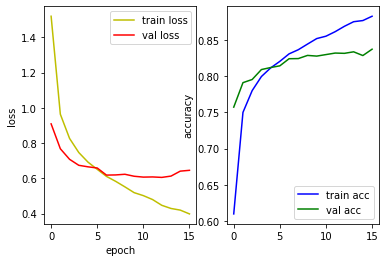

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E384_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 57s 162ms/step - loss: 1.4979 - accuracy: 0.6142 - val_loss: 0.9103 - val_accuracy: 0.7556


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 2/20
329/329 [==============================] - 53s 160ms/step - loss: 0.9285 - accuracy: 0.7580 - val_loss: 0.7402 - val_accuracy: 0.7953


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 3/20
329/329 [==============================] - 53s 160ms/step - loss: 0.8009 - accuracy: 0.7886 - val_loss: 0.6986 - val_accuracy: 0.8054


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 4/20
329/329 [==============================] - 53s 161ms/step - loss: 0.7351 - accuracy: 0.8025 - val_loss: 0.6670 - val_accuracy: 0.8117


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 5/20
329/329 [==============================] - 54s 163ms/step - loss: 0.6820 - accuracy: 0.8140 - val_loss: 0.6525 - val_accuracy: 0.8131


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 6/20
329/329 [==============================] - 54s 164ms/step - loss: 0.6324 - accuracy: 0.8254 - val_loss: 0.6498 - val_accuracy: 0.8158


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 7/20
329/329 [==============================] - 53s 161ms/step - loss: 0.6053 - accuracy: 0.8309 - val_loss: 0.6163 - val_accuracy: 0.8270


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 8/20
329/329 [==============================] - 56s 171ms/step - loss: 0.5664 - accuracy: 0.8413 - val_loss: 0.6204 - val_accuracy: 0.8242
Epoch 9/20
329/329 [==============================] - 54s 163ms/step - loss: 0.5404 - accuracy: 0.8466 - val_loss: 0.5979 - val_accuracy: 0.8301


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 10/20
329/329 [==============================] - 53s 162ms/step - loss: 0.5201 - accuracy: 0.8514 - val_loss: 0.5997 - val_accuracy: 0.8278
Epoch 11/20
329/329 [==============================] - 56s 170ms/step - loss: 0.5005 - accuracy: 0.8573 - val_loss: 0.5903 - val_accuracy: 0.8319


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W4\assets


Epoch 12/20
329/329 [==============================] - 56s 170ms/step - loss: 0.4684 - accuracy: 0.8644 - val_loss: 0.5943 - val_accuracy: 0.8316
Epoch 13/20
329/329 [==============================] - 54s 163ms/step - loss: 0.4440 - accuracy: 0.8702 - val_loss: 0.6246 - val_accuracy: 0.8302
Epoch 14/20
329/329 [==============================] - 54s 166ms/step - loss: 0.4242 - accuracy: 0.8765 - val_loss: 0.6364 - val_accuracy: 0.8263
411/411 - 9s - loss: 0.6270 - accuracy: 0.8324


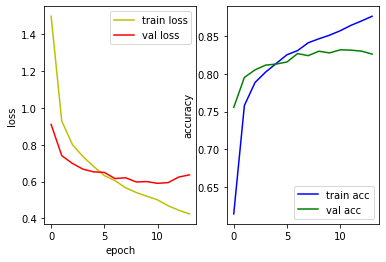

../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_V10000_E384_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
329/329 [==============================] - 57s 162ms/step - loss: 1.5208 - accuracy: 0.6070 - val_loss: 0.8898 - val_accuracy: 0.7592


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 2/20
329/329 [==============================] - 52s 157ms/step - loss: 0.9239 - accuracy: 0.7581 - val_loss: 0.7531 - val_accuracy: 0.7913


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 3/20
329/329 [==============================] - 53s 161ms/step - loss: 0.8002 - accuracy: 0.7880 - val_loss: 0.7018 - val_accuracy: 0.8038


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 4/20
329/329 [==============================] - 53s 161ms/step - loss: 0.7267 - accuracy: 0.8051 - val_loss: 0.6986 - val_accuracy: 0.8067


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 5/20
329/329 [==============================] - 53s 162ms/step - loss: 0.6821 - accuracy: 0.8135 - val_loss: 0.6519 - val_accuracy: 0.8125


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 6/20
329/329 [==============================] - 53s 162ms/step - loss: 0.6454 - accuracy: 0.8229 - val_loss: 0.6165 - val_accuracy: 0.8215


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 7/20
329/329 [==============================] - 53s 162ms/step - loss: 0.6047 - accuracy: 0.8312 - val_loss: 0.6136 - val_accuracy: 0.8231


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 8/20
329/329 [==============================] - 53s 162ms/step - loss: 0.5752 - accuracy: 0.8378 - val_loss: 0.5945 - val_accuracy: 0.8299


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 9/20
329/329 [==============================] - 53s 160ms/step - loss: 0.5462 - accuracy: 0.8458 - val_loss: 0.6071 - val_accuracy: 0.8286
Epoch 10/20
329/329 [==============================] - 52s 160ms/step - loss: 0.5293 - accuracy: 0.8487 - val_loss: 0.5892 - val_accuracy: 0.8294


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 11/20
329/329 [==============================] - 52s 159ms/step - loss: 0.5026 - accuracy: 0.8551 - val_loss: 0.5913 - val_accuracy: 0.8283
Epoch 12/20
329/329 [==============================] - 52s 159ms/step - loss: 0.4771 - accuracy: 0.8632 - val_loss: 0.6195 - val_accuracy: 0.8329
Epoch 13/20
329/329 [==============================] - 52s 160ms/step - loss: 0.4545 - accuracy: 0.8675 - val_loss: 0.5845 - val_accuracy: 0.8362


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./model\W2V_V10000_E384_W5\assets


Epoch 14/20
329/329 [==============================] - 52s 159ms/step - loss: 0.4356 - accuracy: 0.8726 - val_loss: 0.6149 - val_accuracy: 0.8320
Epoch 15/20
329/329 [==============================] - 52s 159ms/step - loss: 0.4130 - accuracy: 0.8780 - val_loss: 0.6207 - val_accuracy: 0.8365
Epoch 16/20
329/329 [==============================] - 53s 160ms/step - loss: 0.3900 - accuracy: 0.8845 - val_loss: 0.6273 - val_accuracy: 0.8344
411/411 - 9s - loss: 0.6323 - accuracy: 0.8351


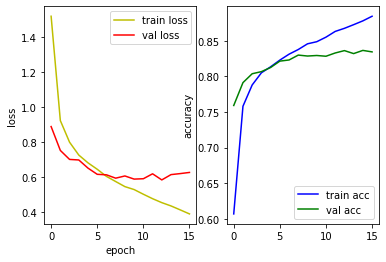

In [36]:
# sop dataset 읽어옴
input_file_name = '../TCL2021_Telco_Embedding_Dataset/dataset/sop_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')
    
# X, Y 추출    
y = df.pop('label_clean')
X = df.pop('sentence')    

# Y labeling
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

MAX_SENTENCE_LEN = 256

histories = dict()
test_scores = dict()

EPOCHS = 20
BATCH_SIZE = 128

result_df = pd.DataFrame(columns=["model", "test_acc", "train_loss", "train_acc", "val_loss", "val_acc"])

for m in MODEL_NAMES:
    # load w2v model
    w2v_model = wv.Word2VecModel()
    model_file_name = w2v_model_file_name_prefix + m
    w2v_model.load(model_file_name)
    
    model_name = "w2v_" + m
    
    print(f'{model_file_name} loaded')
    
    # 전처리 & 벡터화
    preprocessed_X = preprocess_sentence(X, w2v_model, MAX_SENTENCE_LEN, [])
    
    # train, text 분리
    X_train, X_test, y_train, y_test = \
        train_test_split(preprocessed_X, y, test_size=0.2, random_state=42, stratify=y)
    
    # np화
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test  = np.array(X_test)
    y_test  = np.array(y_test)
    
    
    vocab_size, embedding_dim = w2v_model.weight.shape

    model, history, test_score = \
        train_and_evaluate(vocab_size, 
                           embedding_dim,
                           256,
                           256,
                           EPOCHS,
                           BATCH_SIZE,
                           w2v_model.weight,
                           False, # embedding layer를 훈련시킬지, freezing시킬지?
                           0.5, # dropout 비율
                           len(label_encoder.classes_),# class 개수
                           f'./model/W2V_{m}') 

    # 모델 저장
    #model.save(f'./model/{model_name}')    
    
    # 결과 기록
    row = {}
    row["model"] = model_name
    row["test_acc"] = round(test_score[1])
    row["train_loss"] = round(history.history['loss'][-1])
    row["train_acc"] = round(history.history['accuracy'][-1])
    row["val_loss"] = round(history.history['val_loss'][-1])
    row["val_acc"] = round(history.history['val_accuracy'][-1])

    result_df = result_df.append(row, ignore_index=True)

    
# 결과 파일 생성    
result_df.to_csv(f'./model/result.csv', index=False)

In [30]:
history.history

{'loss': [2.5785281658172607,
  1.5745115280151367,
  1.284101128578186,
  1.1204559803009033,
  1.017055630683899,
  0.9461688995361328,
  0.9083524346351624,
  0.8576191067695618,
  0.8150977492332458,
  0.7844281792640686,
  0.7559353113174438,
  0.7190170884132385,
  0.6892322301864624,
  0.6864754557609558],
 'accuracy': [0.30296874046325684,
  0.5845312476158142,
  0.6549999713897705,
  0.699999988079071,
  0.7271875143051147,
  0.7498437762260437,
  0.7514062523841858,
  0.7651562690734863,
  0.7774999737739563,
  0.7846875190734863,
  0.7910937666893005,
  0.8070312738418579,
  0.8082812428474426,
  0.809374988079071],
 'val_loss': [1.7217670679092407,
  1.326813817024231,
  1.109005093574524,
  0.9984827637672424,
  0.9468429684638977,
  0.9190616011619568,
  0.9082462191581726,
  0.9052814245223999,
  0.8661355376243591,
  0.8776029348373413,
  0.8567561507225037,
  0.8616374731063843,
  0.9129886031150818,
  0.8619709014892578],
 'val_accuracy': [0.5306249856948853,
  0.6374

In [23]:
for x, e, r in zip(X_test, np.argmax(model.predict(X_test),-1), y_test):
    if e != r:
        print(' '.join([w2v_model.index2word[t] for t in x]))
        print(label_encoder.inverse_transform([e,r]))
        print('-' * 6)


OSS 시설 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 확인 불가 심사 접수 취소 문의 OSS 시설 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 확인 불가 심사 접수 취소 문의 화면 명 통합 접촉 이력 조회 서비스 번호 주소 서울 해 등 호 장애 현상 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 센터 <UNK> 수건 확인 불가 심사 접수 취소 문의 문 <UNK> 미가 심사 등록 문의 확인 티켓 종료 부탁 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

['SWING Payment' '인터페이스(SMS,MMS포함)']
------
CRM 캠페인 이번 달 약정 만료 고객 캠페인 문자 수신 것 확인 해당 고객 발신 이력 확인 문의 화면 명 서비스 번호 연락처 주소 장애 현상 CRM 캠페인 이번 달 약정 만료 고객 캠페인 문자 수신 것 확인 해당 고객 발신 이력 확인 문의 고객 수신 문 Swing MMS GW 전송 캠페인 번호 ABB ABB MMS GW 고객 전송 결과 확인 필요 MMS GW 부서 문 주신 대상 저희 쪽 발송 이력 확인 확인 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

OSS 시설 건물 가용 정보 조회 유선 화면 내 주소 사용 서비스 조회 외국인 사용 확인 문의 화면 명 건물 가용 정보 조회 유선 서비스 번호 주소 서울 노원구 한글 <UNK> 길 호 장애 현상 OSS 시설 건물 가용 정보 조회 유선 화면 내 주소 사용 서비스 조회 건물 거주 외국인 사용 서비스 번호 확인 문의 외국인 서비스 번호 <UNK> 시작 서비스 번호 확인 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['SWING 유선오더' 'SWING CTC']
------
상품 관리 선택 약정 선택 약정 승계 후 취소 선택 약정 입시 지원금 가입 불가 문의 선택 약정 승계 후 취소 선택 약정 입시 지원금 가입 불가 문의 SM J <UNK> 가입 당시 단말기 사용 중 확인 부탁 요청 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

['SWING 오더 - 무선오더' 'T gate']
------
빌링 청구 요금 조정 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 빌링 청구 요금 조정 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 화면 명 청구 수납 관리 서비스 번호 장애 현상 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['상품-단말기' 'SWING 청구']
------
긴급 청구 청구 내역 월 일 월 수납 국제 전화 요금 언제 사용 청구 문의 화면 명 서비스 번호 증상 오류 메시지 청구 수납 관리 화면 서비스 조회 시 수납 환불 내역 탭 월 수납 원 월 수납 원 확인 개회 선 해당 금액 언제 언제 사용 요금 확인 부탁 요청 차 효정 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['SWING SSO' 'SWING Portal']
------
차 접수 공통 기준 정보 일 이후 결합 가능 권한 센터 부여 확인 특정 상담원 해당 업무 불가 문의 공통 기준 정보 일 이후 결합 가능 권한 센터 부여 확인 특정 상담원 해당 업무 불가 문의 ER 동일 문 의건 결합 진행 중 처리 문의 화면 명 결합 상품 상담원 ID <UNK> B 장애 현상 해당 상담원 TB 가족 프리 가족 할인 TV 플러스 유선 일 제한 예외 권 부여 조직 소속 해당 결합 업무 진행시 서비스 가입 일 개통 가능 제한 이후 확인 문의 조직 권한 권한 적용 개별 권한 신청 지 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



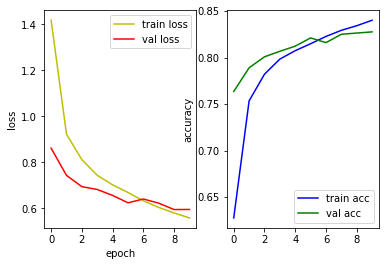

In [53]:
plot_hist(histories['True-128-False-0.5'])

In [73]:
test_scores

{'True-128-False-0.5': [0.6411054134368896, 0.820903480052948]}

# w2v
## 384-all-5 -> 83.964...
## 384-일부-5 -> 83.82...
## 128-all-5 -> 83.088...


# fasttext
## 128-all-5  -> 82.09